In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder




In [ ]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((128, 128))]
)

dataset_train = ImageFolder("../data/clouds_train", transform=train_transforms)


In [15]:
dataloader_train = DataLoader(dataset_train, shuffle=True, batch_size=1)

image, label = next(iter(dataloader_train))
print(image.shape)


torch.Size([1, 3, 128, 128])


In [16]:
image = image.squeeze().permute(1, 2, 0)
print(image.shape)


torch.Size([128, 128, 3])


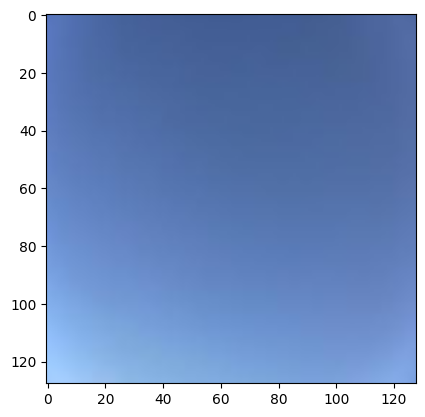

In [17]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.show()


In [18]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
    ]
)

dataset_train = ImageFolder("../data/clouds_train", transform=train_transforms)


In [20]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


In [24]:
# For multiclass classification we use CrossEntropyLoss

net = Net(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x65536 and 16384x7)

In [26]:
from torchmetrics import Recall

recall_per_class = Recall(task="multiclass", num_classes=7, average=None)
recall_micro = Recall(task="multiclass", num_classes=7, average="micro")
recall_macro = Recall(task="multiclass", num_classes=7, average="macro")
recall_weighted = Recall(task="multiclass", num_classes=7, average="weighted")


In [ ]:
from torchmetrics import Precision, Recall

metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")
metric_precision_per_class = Precision(task="multiclass", num_classes=7, average=None)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images.float())
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
        metric_precision_per_class(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
precision_per_class = metric_precision_per_class.compute()
ic(precision)
ic(recall)
ic(precision_per_class)


In [ ]:
dataset_train.class_to_idx
